In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import aslinearoperator, eigs
from scipy.sparse import diags
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Computer Modern Serif"]
})
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import RBF, Quadratic, Linear, Matern
from DynamicalSystems.reduced_rank_regression import reduced_rank_regression, _low_rank_projector
from DynamicalSystems.utils import plot_eigs
import seaborn as sns
def implied_timescale(eigenvalues, stride, timestep):
    return (stride*timestep)/np.log(eigenvalues)

#### Standardizing dataset

In [2]:
df_pd = pd.read_pickle("full_dataframe").interpolate()
#Get stations and measurements 
stations = set()
measurements = set()
for col in df_pd.columns:
    meas, stat = col.split("_")
    measurements.add(meas)
    stations.add(stat)

standardizing_parameters = dict() # (std, mean)

for m in measurements:
    std = df_pd.filter(regex= m + "_*").std().mean()
    mean = df_pd.filter(regex= m + "_*").mean().mean()
    standardizing_parameters[m] = (std, mean)
    df_pd[df_pd.filter(regex= m + "_*").columns] -= mean
    df_pd[df_pd.filter(regex= m + "_*").columns] /= std
df = df_pd.filter(regex= "DEWP*").to_numpy()
#df = df_pd.to_numpy()

In [3]:
df.shape

(35064, 12)

#### Selecting timestep, kernel, desired rank & regularizer

In [32]:
def subsample_data(df, n_timesteps, full_data=True, shift = None):
    """Subsample the dataframe every timestep

    Args:
        df (np.ndarray): dataframe
        n_timesteps (int): number of original timesteps to skip because of subsamplign
        full_data (bool, optional): Retain full data or subsample only one of the possible n_timesteps subsequences. Defaults to True.
    """
    nan_mask = np.isnan(df).any(axis=1)
    dataset_indexes = []
    if shift is None:
        shift = 0
    if full_data:
        for idx, val in enumerate(nan_mask[:-n_timesteps -shift]):
            if val == False:
                if nan_mask[idx + n_timesteps] == False:
                    dataset_indexes.append((idx, idx+ n_timesteps))
    else:
        for idx, val in enumerate(nan_mask[::(n_timesteps + shift)][:-1]):
            if val == False:
                if nan_mask[::n_timesteps][idx + 1] == False:
                    dataset_indexes.append((idx*n_timesteps, (idx+1)*n_timesteps))

    dataset_indexes = np.array(dataset_indexes)
    if shift == 0:
        inputs = df[dataset_indexes[:,0]]
        evolved_inputs = df[dataset_indexes[:,1]]
    else:
        inputs = np.hstack([df[dataset_indexes[:,0] + i*shift] for i in range(2)])
        evolved_inputs = np.hstack([df[dataset_indexes[:,1] + i*shift] for i in range(2)])
    return inputs, evolved_inputs

In [87]:
n_timesteps = 24*30 #In hours
rank = 10
regularizer = 1e-7
l = np.float32(np.sqrt(df.shape[1]))
X, Y = subsample_data(df, n_timesteps, full_data=False, shift=24*30)
nu = 1.5
kernel = Matern(nu = nu, length_scale=l)

In [82]:
evals, evecs = reduced_rank_regression(X, Y, kernel, rank, regularizer=regularizer)

Low rank projection


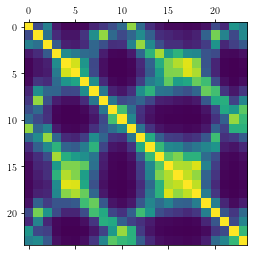

In [88]:
plt.matshow(kernel.to_numpy(X))

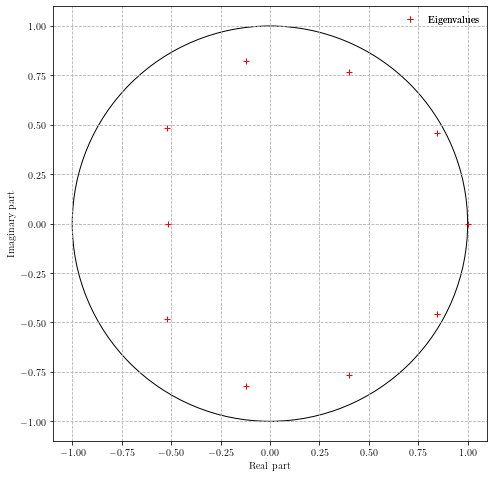

In [83]:
plot_eigs(evals)

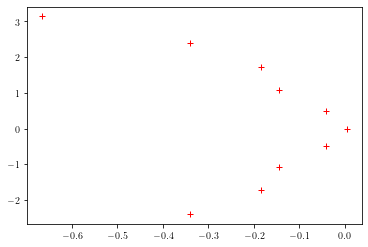

In [84]:
plt.plot(np.real(np.log(evals)), np.imag(np.log(evals)), 'r+')

In [85]:
print(np.imag(implied_timescale(evals, n_timesteps, 1))/(24*30))

[ 0.         -1.99675435  1.99675435 -0.4092862   0.4092862  -0.30464407
 -0.90225113  0.90225113 -0.57538299  0.57538299]


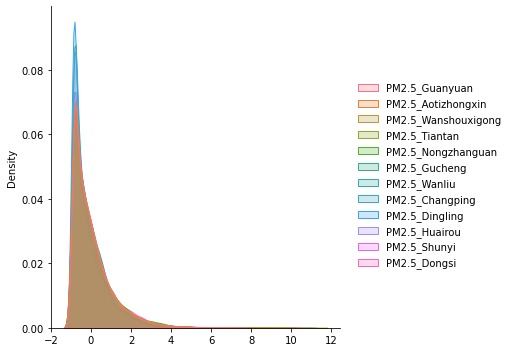

In [109]:
import seaborn as sns
ax = sns.displot(df_pd.filter(regex="PM2.5_*"), kind='kde', fill=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


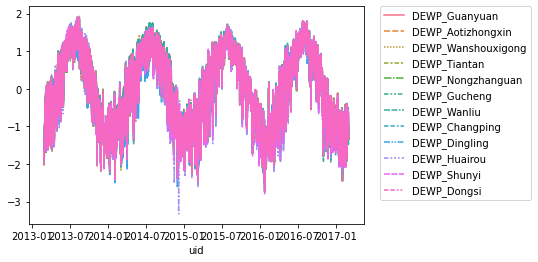

In [16]:
pm25_df = df_pd.filter(regex= "DEWP*")
ax = sns.lineplot(data=pm25_df, ci=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/tmp/ipykernel_1454261/3063865643.py:15: RuntimeWarning: divide by zero encountered in true_divide
  t_h = 1/f_oneside / (60 * 60)


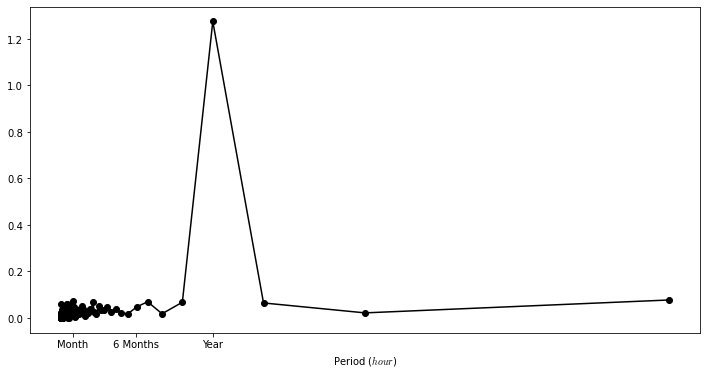

In [30]:
from scipy.fftpack import fft, ifft
X = fft(pm25_df["DEWP_Guanyuan"].to_numpy())
N = len(X)
n = np.arange(N)
# get the sampling rate
sr = 1 / (60*60)
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]
# convert frequency to hour
t_h = 1/f_oneside / (60 * 60)

plt.figure(figsize=(12,6))
plt.plot(t_h, np.abs(X[:n_oneside])/n_oneside, 'ko-')
plt.xticks([24*30, 24*30*6, 24*365], ["Month", "6 Months", "Year"])
plt.xlabel('Period ($hour$)')
plt.show()

#### Sine wave

In [298]:
x = np.arange(0,10,0.01)
f = 2
y = np.sin(f*x)[:, np.newaxis]
_y = np.sin(f*x)
shift = 50
y_shift = np.empty((x.shape[0] -shift,2), dtype = x.dtype)
y_shift[:,0] = _y[:-shift]
y_shift[:,1] = _y[shift:]
kernel_RBF = RBF(length_scale=1)
kernel_linear = Linear(coef0=0.)
regularizer = 1e-6

In [308]:
K = kernel_RBF.to_numpy(y[:-1])
K_shift = kernel_RBF.to_numpy(y_shift[:-1])

Text(0.5, 1.0, 'Shifted')

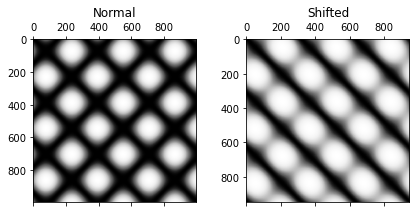

In [309]:
fig, ax = plt.subplots(ncols = 2, figsize=(7,3))
ax[0].matshow(K, cmap='Greys')
ax[1].matshow(K_shift, cmap='Greys')
ax[0].set_title("Normal")
ax[1].set_title("Shifted")

In [301]:
evals, evecs = reduced_rank_regression(y_shift[:-1], y_shift[1:], kernel_RBF, 8, regularizer)

Low rank projection


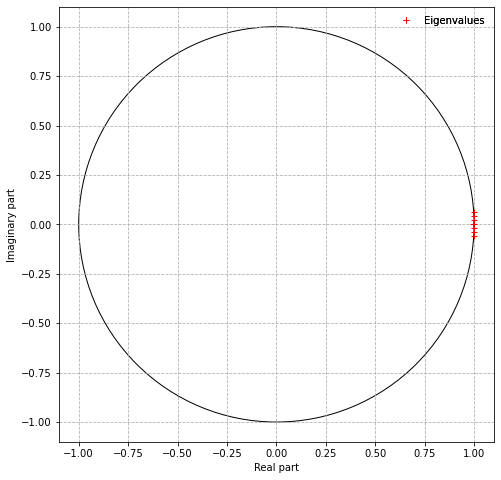

[-0.16543712  0.16543712 -0.24632395  0.24632395  0.         -0.
 -0.49987882  0.49987882]


In [302]:
plot_eigs(evals)
print(np.imag(implied_timescale(evals,1,0.01)))

In [303]:
implied_timescale(evals,1,0.01)

array([-4.44557422e-04-0.16543712j, -4.44557422e-04+0.16543712j,
       -4.32988299e-04-0.24632395j, -4.32988299e-04+0.24632395j,
        1.55745918e+04+0.j        , -2.75626784e+00-0.j        ,
       -1.23868970e-04-0.49987882j, -1.23868970e-04+0.49987882j])

In [233]:
K = kernel_RBF.to_numpy(y)
K_L = kernel_linear.to_numpy(y)

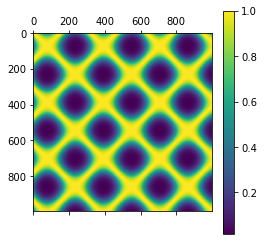

In [234]:
plt.matshow(K)
plt.colorbar()